In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -q val2017.zip 
!unzip -q train2017.zip
!unzip -q annotations_trainval2017.zip
!rm -rf val2017.zip
!rm -rf train2017.zip
!rm -rf annotations_trainval2017.zip
!mkdir coco
!mv val2017 coco
!mv annotations coco
!mv train2017 coco

# Contents 

We will implement a Vision Large Language Model (VLLM) from scratch. We will mainly use pytorch and huggingface transformers. 

This notebook is inspired by [Mini-GPT4](https://github.com/Vision-CAIR/MiniGPT-4/tree/main/minigpt4) and [alexander-moore repo](https://github.com/alexander-moore/vlm/blob/main/vlm)

# This Lab Approach

- explain abstract concept
- explain input and output
- explain functionality (what we are trying to do?)
- dive deeper into the implementation
- explain specifics
- Engage!!!
- give time for questions and students to solve
- provide solution

# What we will Achieve today!!

![Screenshot 2024-10-12 at 8.46.57 AM.png](<attachment:Screenshot 2024-10-12 at 8.46.57 AM.png>)
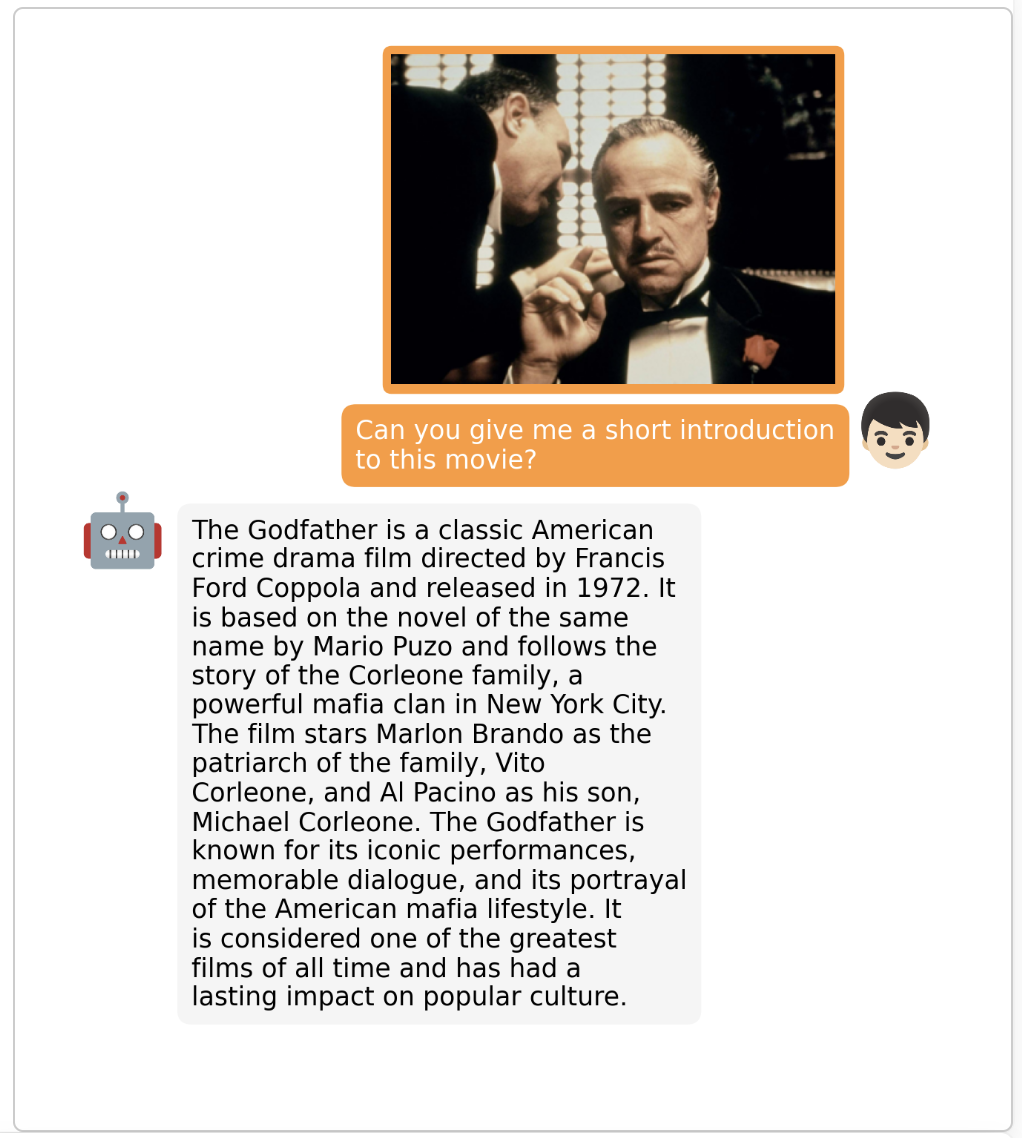

# Imports

In [30]:
from transformers import AutoModelForCausalLM, AutoTokenizer, ViTImageProcessor, ViTForImageClassification
import torch
import torch.nn as nn
from PIL import Image
import requests
import torchvision
import random
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision.transforms import ToTensor, Compose, Resize
from random import choice
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# From LLM to VLLM

![Screenshot 2024-10-12 at 9.09.54 AM.png](<attachment:Screenshot 2024-10-12 at 9.09.54 AM.png>)
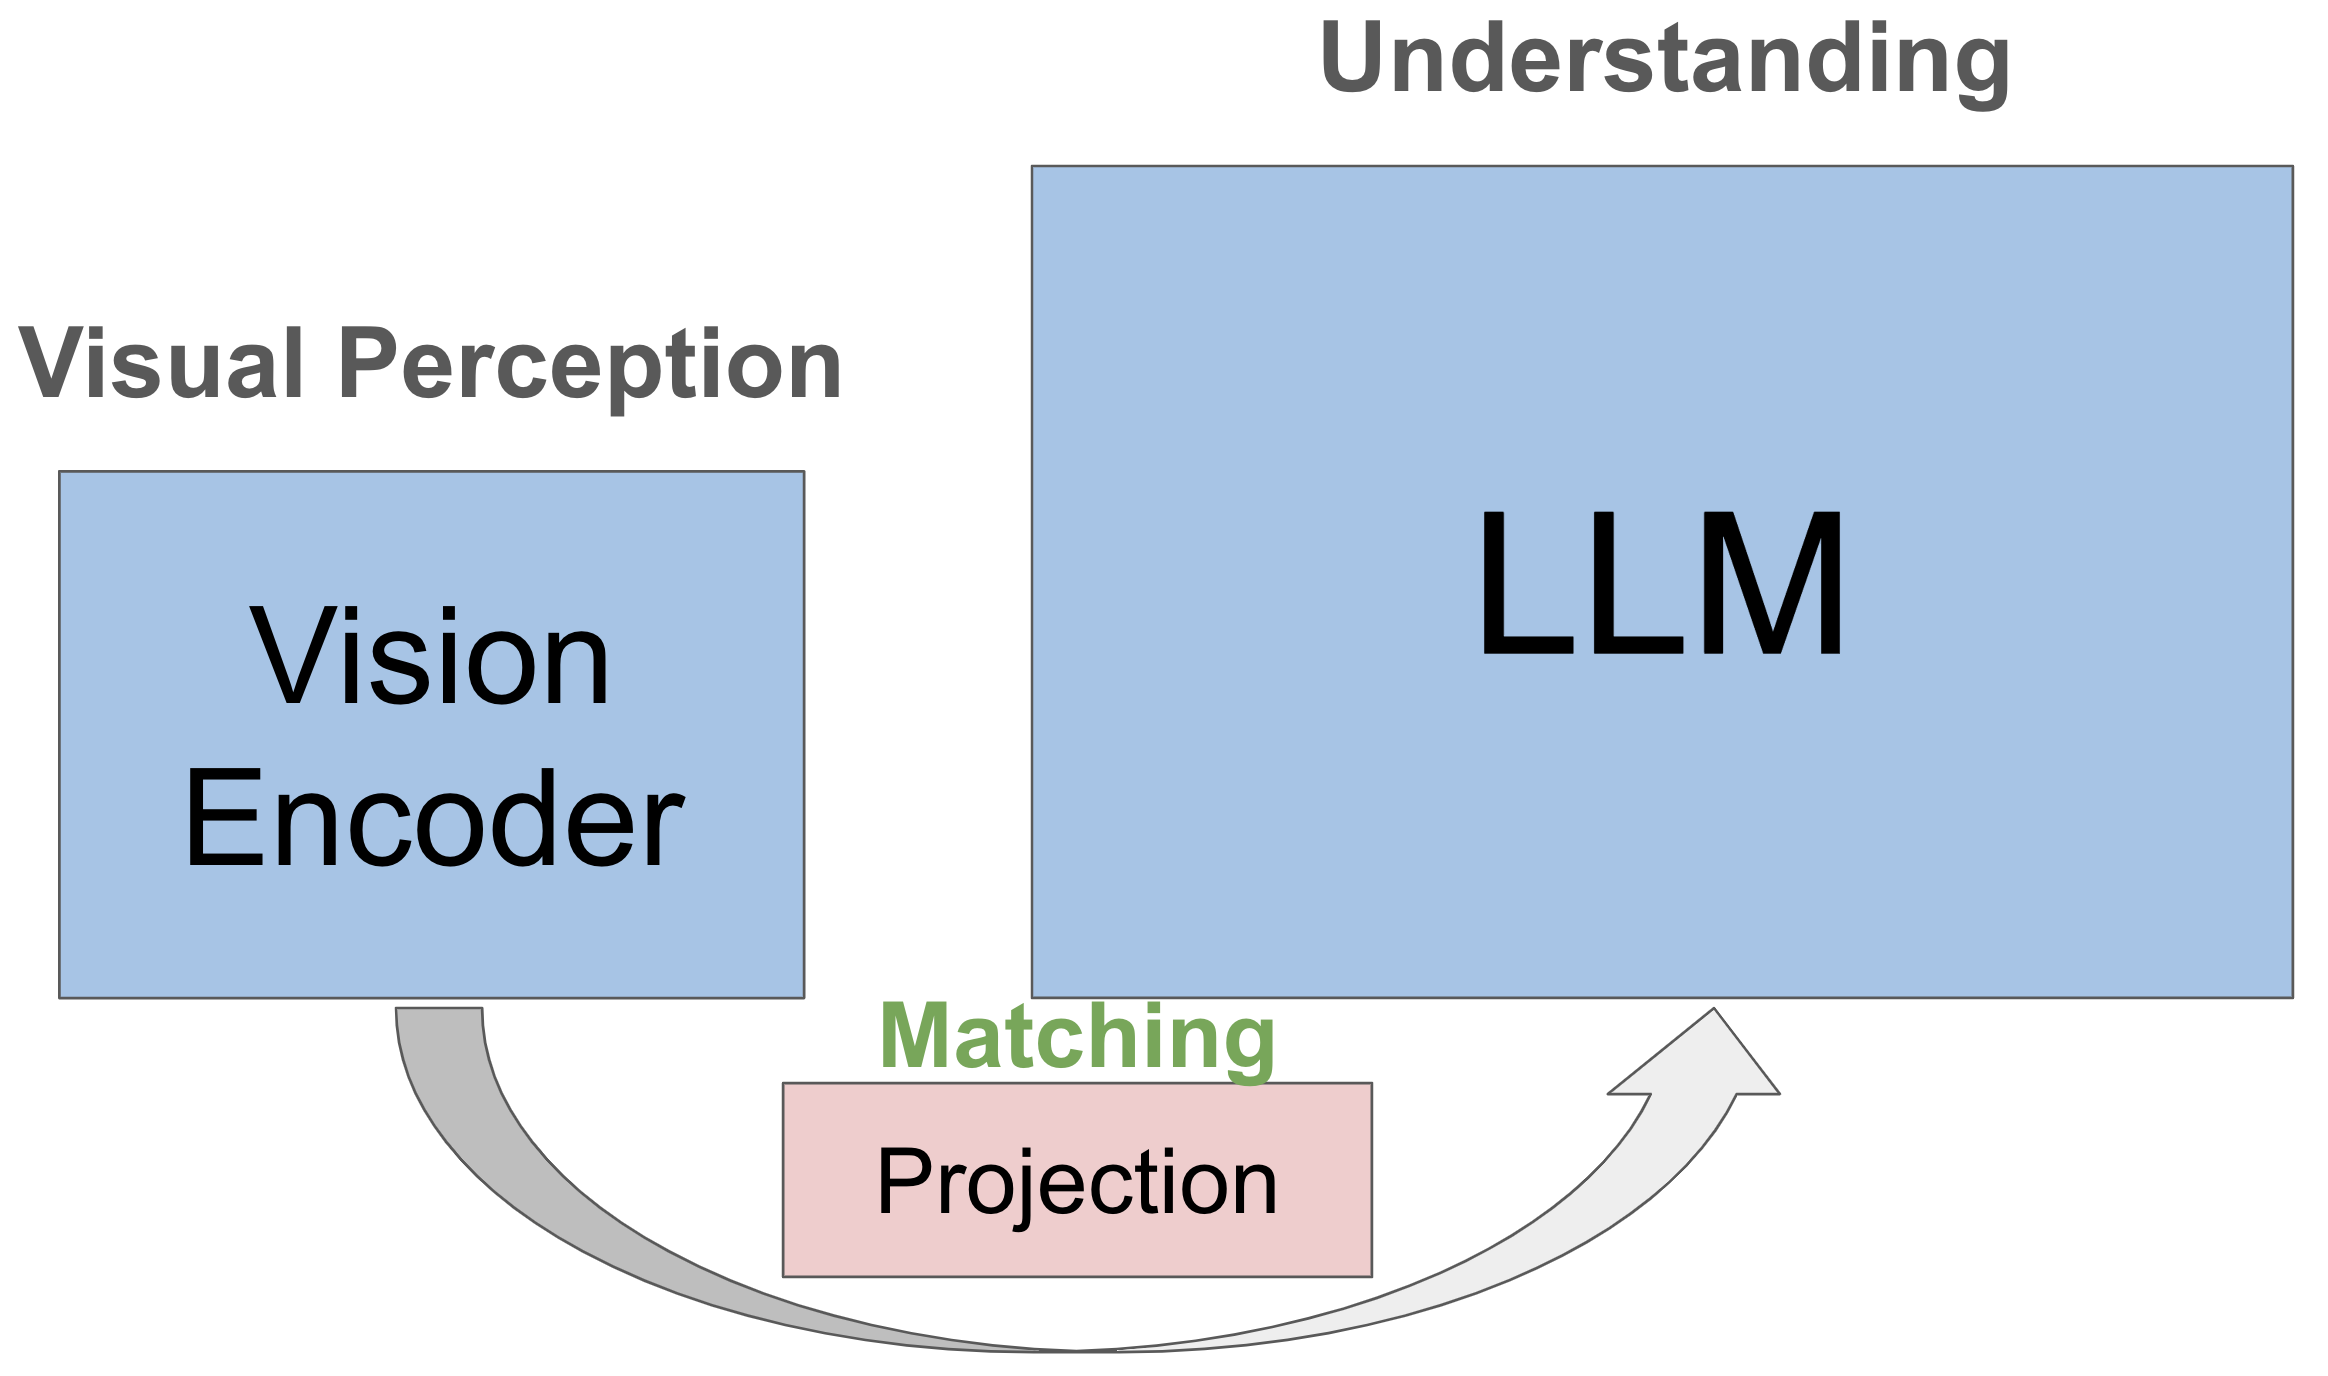

# Lets start with LLM

In [3]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval().to(device);

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Testing the LLM

In [ ]:
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

In [4]:
model_inputs = ... #TODO: Use the tokenizer to get tokens from text

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)

generated_ids = [
    ... #TODO: Get only the generations from the generated_ids (ignore input_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [5]:
print(response)

'A large language model (LLM) is an artificial intelligence technology that can generate human-like text based on input data such as sentences or paragraphs. These models use deep learning techniques and neural networks to learn patterns in the vast amount of text data they are trained on.\n\nThe development of LLMs has been ongoing for many years, with breakthroughs occurring at various stages. In recent years, there have been significant advancements in LLM research, leading to more sophisticated models that can produce coherent and contextually appropriate responses. Some well-known LLMs include BERT, GPT-3, and Qwen.'

In [6]:
# TODO: Freeze the LLM gradients

### Understanding the embeddings

In [61]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151667, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Linear(in_featur

In [7]:
model.get_input_embeddings()

Embedding(151936, 896)

In [8]:
model.get_input_embeddings()(torch.tensor(4).to(device)).shape

torch.Size([896])

### Use the embeddings to do the generation

In [ ]:
# TODO: Class practice

# Now let's see The Vision encoder model

In [9]:
image_encoder_str = "openai/clip-vit-base-patch32"
vision_processor = ViTImageProcessor.from_pretrained(image_encoder_str)
vision_model = ViTForImageClassification.from_pretrained(image_encoder_str)

You are using a model of type clip to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch32 and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.cls_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layern

In [10]:
vision_model.to(device)
vision_model.requires_grad = False

### Test the Vision encoder

In [11]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [12]:
inputs = vision_processor(images=image, return_tensors="pt")
outputs = vision_model(**inputs.to(device), output_hidden_states = True)

In [13]:
embeddings = outputs.hidden_states[-1]
print('made embedings', embeddings.shape)

made embedings torch.Size([1, 197, 768])


# Nice! Now let's do the connection

### Helper Functions

In [14]:
def get_in_size(image_encoder):
    return image_encoder.config.hidden_size
def get_out_size(lang_tokenizer, llm):
    input_ids = lang_tokenizer.encode('hi', add_special_tokens=True, return_tensors="pt").to(llm.device)
    vec = llm.get_input_embeddings()(input_ids)
    embedded_tokens_size = vec.size()[-1]
    return embedded_tokens_size

In [15]:
get_in_size(vision_model)

768

In [16]:
get_out_size(tokenizer, model)

896

### Projection Layer

In [18]:
class ProjectionLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ProjectionLayer, self).__init__()
        self.fc1 = nn.Linear(in_dim, out_dim)
        self.fc2 = ... # TODO: Add another linear layer
        self.activ = nn.GELU()
    
    def forward(self, x):
        return ... # TODO: Implement the forward pass

In [ ]:
insize = get_in_size(vision_model)
outsize = get_out_size(tokenizer, model)
projection_layer = ProjectionLayer(insize, outsize)

# Let's Put it all together - Create the VLLM

In [20]:
class VisionLanguageModel(nn.Module):
    def __init__(self,
                 vision_processor,
                 vision_encoder,
                 projection_layer,
                 language_tokenizer,
                 language_model,
                 device='cpu'):
        super(VisionLanguageModel, self).__init__()
        self.device = device
        
        self.max_context_len = 256
        self.max_txt_len = 128
        self.end_sym = language_tokenizer.eos_token

        self.vision_processor = vision_processor
        self.vision_encoder = vision_encoder.to(device)
        self.projection_layer = projection_layer.to(device)
        
        self.language_model = language_model
        self.language_tokenizer = language_tokenizer
        
        imstart_str = '<|imgstart|>'
        imend_str = '<|imgend|>'
        language_prompt = f"Please provide a detailed description of this Image {imstart_str}<ImageHere>{imend_str}"
        messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful Vision Aware assistant."},
            {"role": "user", "content": language_prompt}
        ]
        self.instruction = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        language_tokenizer.add_tokens(imstart_str, special_tokens = True)
        language_tokenizer.add_tokens(imend_str, special_tokens = True)
        
        # Update langauge model's token embedding matrix
        self.language_model.resize_token_embeddings(len(self.language_tokenizer))
        
    def image_forward(self, image):
        inputs = ... #TODO: Process the image using the vision processor

        encoded_image = ... #TODO: Get the hidden states from the vision encoder
        encoded_image = encoded_image.hidden_states[-1]

        embedded_image = ... #TODO: Project the image embeddings using the projection layer
        
        return embedded_image
    
    def embed_tokens(self, tokens):
        return self.language_model.get_input_embeddings()(tokens)
    
    def prompt_wrap(self, img_embeds, prompts):
        emb_lists = []
        if isinstance(prompts, str):
            prompts = [prompts] * len(img_embeds)
        for idx, (each_img_embed, each_prompt) in enumerate(zip(img_embeds, prompts)):
            pn = each_img_embed.shape[-2]
            p_segs = each_prompt.split('<ImageHere>')
            interleave_emb = []
            for idx, seg in enumerate(p_segs[:-1]):
                p_tokens = self.language_tokenizer(
                    seg, return_tensors="pt", add_special_tokens=False).to(img_embeds.device)
                p_embed = self.embed_tokens(p_tokens.input_ids)
                interleave_emb.append(torch.cat([p_embed, each_img_embed[None][:, idx * pn:(idx + 1) * pn]], dim=1))
            wrapped_emb = torch.cat(interleave_emb, dim=1)
            p_tokens = self.language_tokenizer(
                p_segs[-1], return_tensors="pt", add_special_tokens=False).to(img_embeds.device)
            p_embed = self.embed_tokens(p_tokens.input_ids)
            wrapped_emb = torch.cat([wrapped_emb, p_embed], dim=1)
            emb_lists.append(wrapped_emb)

        emb_lens = [emb.shape[1] for emb in emb_lists]
        pad_emb = self.embed_tokens(torch.tensor(self.language_tokenizer.pad_token_id, device=img_embeds.device))

        max_length = max(emb_lens) if max(emb_lens) < self.max_context_len else self.max_context_len
        wrapped_embs = pad_emb.expand(len(emb_lens), max_length, -1).clone()
        wrapped_atts = torch.zeros([len(emb_lens), max_length], dtype=torch.int, device=img_embeds.device)
        
        for i, emb in enumerate(emb_lists):
            length = emb_lens[i] if emb_lens[i] < self.max_context_len else self.max_context_len
            wrapped_embs[i, :length] = emb[:, :length]
            wrapped_atts[i, :length] = 1
        return wrapped_embs, wrapped_atts

    def concat_emb_input_output(self, input_embs, input_atts, output_embs, output_atts):
        """
        Concatenate the batched input embedding and batched output embedding together.
        Both the input and the output embedding should be right padded.
        """
        input_lens = []
        cat_embs = []
        cat_atts = []
        for i in range(input_embs.size(0)):
            input_len = input_atts[i].sum()
            input_lens.append(input_len)
            cat_embs.append(
                torch.cat([
                    input_embs[i][:input_len],
                    output_embs[i],
                    input_embs[i][input_len:]
                ])
            )
            cat_atts.append(
                torch.cat([
                    input_atts[i][:input_len],
                    output_atts[i],
                    input_atts[i][input_len:]
                ])
            )
        cat_embs = torch.stack(cat_embs)
        cat_atts = torch.stack(cat_atts)
        return cat_embs, cat_atts, input_lens

    def forward(self, batch):

        embedded_image = self.image_forward(batch['image'])

        cond_embeds, cond_atts = self.prompt_wrap(embedded_image, self.instruction)
        
        self.language_tokenizer.padding_side = "right"
        text = [t + self.end_sym for t in batch["caption"]]
        regress_tokens = self.language_tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                truncation=True,
                max_length=self.max_txt_len,
                add_special_tokens=False
            ).to(self.device)
        regress_token_ids = regress_tokens.input_ids
        regress_atts = regress_tokens.attention_mask
        part_targets = regress_token_ids.masked_fill(
            regress_token_ids == self.language_tokenizer.pad_token_id, -100
        )

        regress_embeds = ... #TODO: Get the embeddings for the regress_tokens

        inputs_embeds, attention_mask, input_lens = \
                    self.concat_emb_input_output(cond_embeds, cond_atts, regress_embeds, regress_atts)

        targets = torch.ones([inputs_embeds.shape[0], inputs_embeds.shape[1]],
                                    dtype=torch.long).to(self.device).fill_(-100)

        for i, target in enumerate(part_targets):
            targets[i, input_lens[i]:input_lens[i]+len(target)] = target

        outputs = ... # TODO: Get the outputs from the language model
        loss = outputs.loss

        return {"loss": loss}
    
    @torch.no_grad()
    def generate(self, batch, max_new_tokens):

        #TODO: Write the generation function
        
        embedded_image = ... #TODO: Get the image embeddings

        cond_embeds, cond_atts = ... #TODO: Wrap the image embeddings with the instruction

        outputs = ... #TODO: Generate the outputs from the language model
        return self.language_tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [21]:
vlm = VisionLanguageModel(vision_processor,
                          vision_model,
                          projection_layer,
                          tokenizer,
                          model,
                          device)

In [22]:
for name, param in vlm.vision_encoder.named_parameters():
    param.requires_grad = False
    
for name, param in vlm.language_model.named_parameters():
    param.requires_grad = False

# DataLoader

In [23]:
def get_coco_dataset(mode = 'train'):
    """
    Abcd
    """
    coco_dataset = dset.CocoDetection(root = f'coco/{mode}2017',
                                      annFile = f'coco/annotations/captions_{mode}2017.json')
    return Coco_Wrapper(coco_dataset)
    
class Coco_Wrapper(Dataset):
    def __init__(self, coco_dataset):
        self.dataset = coco_dataset
        self.totensor = ToTensor()
        self.resize = Resize((224, 224), antialias=True)
        self.len = len(coco_dataset)

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        """
        Get and transform items
        """
        img, target = self.dataset[idx]
        image = self.totensor(img)
        image = self.resize(image)
        
        caption = choice(target)['caption']
        
        sample = {'image': image,
                  'caption': caption}
        return sample

In [24]:

train_dataset = get_coco_dataset(mode='train')
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

val_dataset = get_coco_dataset(mode = 'val')
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)

print(train_dataset, val_dataset)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
<__main__.Coco_Wrapper object at 0x1537f5f43610> <__main__.Coco_Wrapper object at 0x1537f5f17df0>


# Test The VLLM

In [25]:
for bi, batch in enumerate(train_dataloader):
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [26]:
res = vlm(batch)

In [27]:
out = vlm.generate(batch, 100)

# Training

In [28]:
# implement a val step
def val_step():
    model.eval()
    losses = []
    for bi, batch in enumerate(tqdm(val_dataloader)):
        outputs = model(batch)
        loss = outputs['loss']
        losses.append(loss.data.item())
    model.train()
    return sum(losses) / len(losses)

def train_model(model, n_epochs):
    model = model.to(device)
    model.train()
    
    for _ in range(n_epochs):
        losses = []
        for bi, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            
            outputs = model(batch)
            loss = outputs['loss']
            ... #TODO: Backpropagate the loss
            ... #TODO: Update the model weights (What are the weights we are updating?)
            
            losses.append(loss.data.item())
            if bi % 100 == 0:
                print(f"Train Loss: {sum(losses) / len(losses)}")
            
        val_metrics = val_step()
        print(f"Val loss: {val_metrics}")

In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(vlm.parameters(), lr = 3e-4)
n_epochs = 2

train_model(vlm, n_epochs)

# Testing

In [57]:
generations = vlm.generate(batch, 100)

In [58]:
idx = 24
img = batch['image'][idx]
caption = batch['caption'][idx]

In [ ]:
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f"Real Caption: {caption}\nGenerated Caption: {generations[idx]}")
plt.show()